In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("seaborn")

## Ten-armed bandit testbed

We want to randomly generate the actual value function $q_*(a)$ for a problem with 10 possible actions $a$. From there we construct stationary PDFs of the rewards $R_t$, which we assume here to be Gaussian.

We assume that the rewards for each action are drawn from a Gaussian distribution with mean $q_*(a)$ and unit variance.

A simple bandit algorithm:

In [2]:
def greedy(values):
    """
    The greedy algorithm always chooses the greedy action,
    that is, the action with highest percieved (or estimated) value.
    Ties are settled (uniformly) randomly.
    
    Parameters
    ----------
    values : np.ndarray
        Estimated (or percieved) values of each action
    
    Returns
    -------
    action : int
        The chosen (greedy) action to take    
    """
    # We can't just use np.argmax(), since that only returns
    # the first occurrence of the maximum
    max_value = np.max(values)
    optimal_actions = np.argwhere(values == max_value).reshape(-1)

    return np.random.choice(optimal_actions)

In [3]:
class Bandit():
    """
    A k-armed bandit problem with stationary, unit-variance Gaussian-distributed
    rewards and randomly generated Gaussian-distributed values.
    
    Parameters
    ----------
    n_arms : int
        The number of arms (or actions)
    
    Attributes
    ----------
    n_arms : int
        The number of arms (or actions)
    values : array of shape (n_arms, 1)
        The value of each action
    """
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.values = np.random.normal(loc=0, scale=1, size=n_arms)
        
    def __call__(self, action):
        """
        Sample the reward from a Gaussian distribution with mean
        given by `values` and unit variance.
        
        Parameters
        ----------
        action : int
            The index of the action taken
        
        Return
        ------
        reward : float
            The value of the reward recieved
        """
        return np.random.normal(loc=self.values[action], scale=1)


In [12]:
def run_testbed(n_actions, n_steps):
    bandit = Bandit(n_actions)

    estimated_values = np.zeros(n_actions) # TODO: Make this and below 2D, with second dimension being timesteps
    actions_taken = np.zeros(n_actions)

    actions = np.empty(n_steps, dtype=np.int64)
    rewards = np.empty(n_steps)
    
    step = 1
    for i in range(n_steps):
        # Decide on an action
        actions[i] = greedy(estimated_values)

        # Take the action and receive a reward
        rewards[i] = bandit(actions[i])

        # Update estimated values based on the action taken and the reward recieved
        # TODO: Make this a function
        actions_taken[actions[i]] += 1
        estimated_values[actions[i]] += 1 / (actions_taken[actions[i]]) * (rewards[i] - estimated_values[actions[i]])
    
    return actions, rewards

In [5]:
def run_many(n_actions, n_steps, n_runs):
    actions = np.empty((n_steps, n_runs), dtype=np.int64)
    rewards = np.empty((n_steps, n_runs))
    
    for i in range(n_runs):
        actions[:, i], rewards[:, i] = run_testbed(n_actions, n_steps)
    
    return actions, rewards

In [6]:
actions, rewards = run_many(10, 1000, 2000)

In [7]:
def running_average(x):
    """
    Calculate the running average of an array.
    
    Parameters
    ----------
    x : array
        The input array
    
    Returns
    -------
    ave : array
        The running average of x
    """
    if x.ndim == 1:
        x = x.reshape((-1,1))
    ave = np.empty(x.shape)
    
    ave[0, :] = x[0, :]
    for i in range(1, len(ave)):
        ave[i, :] = ave[i-1, :] + 1 / (i + 1) * (x[i, :] - ave[i-1,:])
    
    return ave

assert all(running_average(np.array([0, 5, 4, 9, 3])) == np.reshape([0, 2.5, 3, 4.5, 4.2], (-1, 1)))

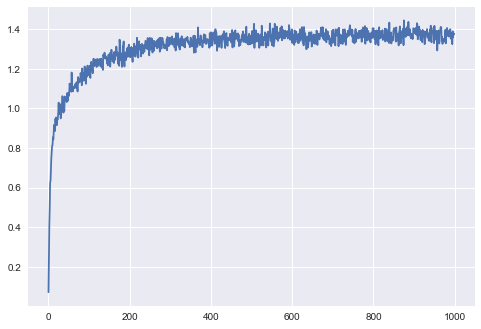

In [32]:
plt.plot(rewards.mean(axis=1));

In [17]:
def eps_greedy(values, eps):
    """
    The greedy algorithm always chooses the greedy action,
    that is, the action with highest percieved (or estimated) value.
    Ties are settled (uniformly) randomly.
    
    Parameters
    ----------
    values : np.ndarray
        Estimated (or percieved) values of each action
    
    Returns
    -------
    action : int
        The chosen (greedy) action to take    
    """
    explore = np.random.choice([True, False], p=[eps, 1 - eps])
    
    if explore:
        return np.random.randint(0, len(values))
    else:
        max_value = np.max(values)
        optimal_actions = np.argwhere(values == max_value).reshape(-1)

        return np.random.choice(optimal_actions)

In [18]:
def run_testbed(n_actions, n_steps, algo, **kwargs):
    bandit = Bandit(n_actions)

    estimated_values = np.zeros(n_actions) # TODO: Make this and below 2D, with second dimension being timesteps
    actions_taken = np.zeros(n_actions)

    actions = np.empty(n_steps, dtype=np.int64)
    rewards = np.empty(n_steps)
    
    step = 1
    for i in range(n_steps):
        # Decide on an action
        actions[i] = algo(estimated_values, **kwargs)

        # Take the action and receive a reward
        rewards[i] = bandit(actions[i])

        # Update estimated values based on the action taken and the reward recieved
        # TODO: Make this a function
        actions_taken[actions[i]] += 1
        estimated_values[actions[i]] += 1 / (actions_taken[actions[i]]) * (rewards[i] - estimated_values[actions[i]])
    
    return actions, rewards

In [25]:
def run_many(n_actions, n_steps, n_runs, algo, **kwargs):
    actions = np.empty((n_steps, n_runs), dtype=np.int64)
    rewards = np.empty((n_steps, n_runs))
    
    for i in range(n_runs):
        actions[:, i], rewards[:, i] = run_testbed(n_actions, n_steps, algo, **kwargs)
    
    return actions, rewards

In [27]:
actions, rewards = run_many(10, 1000, 2000, eps_greedy, eps=0.1)

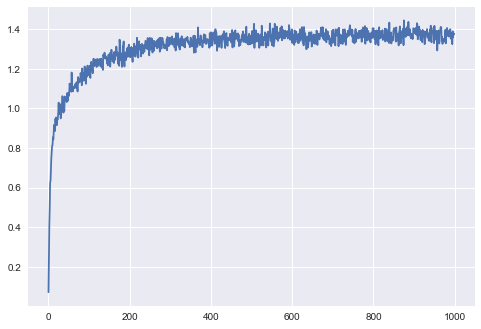

In [30]:
plt.plot(rewards.mean(axis=1));